# Benchmarking Bilby on NERSC using `bilby_pipe`

## Here, we have the results for the same sampler settings, and different algorithms.

From private communication with Nikhil Sarin, developer of bilby

```
No, I think that it's not even sampler settings really. Like this probably depends very strongly on the algorithm e.g., rejection sampling vs rwalk and stuff like that.
```

Below we show the results of a debug job that ran for 30 minutes. `bilby_pipe` jobs are split into four steps, with the second step being the most computationally intensive (running the MCMC chains). All of the 30 minute debug jobs were unable to complete the second step and ran until timeout.

The jobs were ran with all other parameters identical, using the same gravitational wave event. This event has a network SNR of 9, which is the minimum for usage in our studies. Higher SNR will converge faster, and therefore be computationally less expensive. Therefore, this represents a worst-case event for our studies.

Below we present the `seff` results for step 2 of the full job submission, since step 2 is the most computationally expensive. In all cases, we used one node, with 256 CPUs and GB of memory.

#### Plotting tools for results

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
algorithms = ["act-walk","unif","acceptance-walk","rwalk","slice","rslice","hslice","rwalk_dynesty"] # Algorithm name
cpu = [18.96,9.65,44.61,0.52,7.75,26.42,53.59,24.55,] # CPU efficiency [%]
memory = [99.72,50.79,55.33,56.85,50.18,45.36,48.89,57.44] # Memory efficiency [%]
jobIDs = [37802468,37872626,37870741,37873698,37874103,37874301,37874598,37874646] # The jobIDs
color = ["red"]*4+["blue"]*2 + ["red"] + ["blue"]

### Results

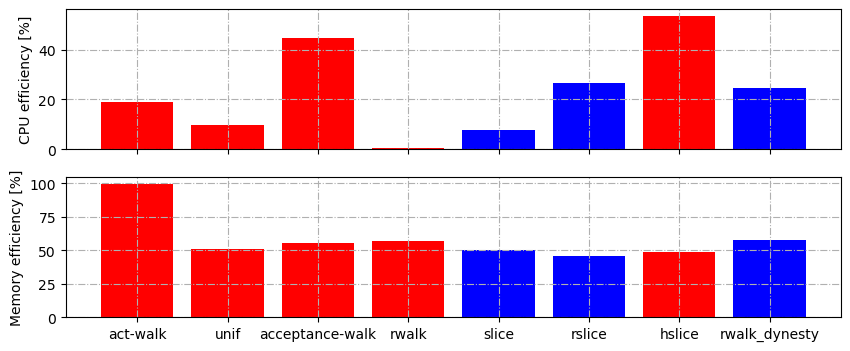

In [14]:
fig,axs = plt.subplots(2,1,figsize=[10,4],sharex=True)

axs[0].bar(algorithms,cpu,color=color)
axs[0].set_ylabel("CPU efficiency [%]")


axs[1].bar(algorithms,memory,color=color)
axs[1].set_ylabel("Memory efficiency [%]")

for ax in axs:
    ax.grid(ls="-.")

## Based on the above, we find the `hslice` and `acceptance-walk` samplers algorithm is the most CPU-efficient.

# Here, we provide the results from a production level job that ran to completion using the `acceptance-walk` and `hslice` sampler algorithms. 

Here we provide the results from the compute heavy job only. The other jobs were identical and did not depend on the sampler method

##### `acceptance-walk`

Job ID: 37945469

Cluster: perlmutter

User/Group: seanmacb/seanmacb

State: COMPLETED (exit code 0)

Nodes: 1

Cores per node: 256

CPU Utilized: 2-11:27:32

CPU Efficiency: 48.11% of 5-03:35:28 core-walltime

Job Wall-clock time: 00:28:58

Memory Utilized: 3.99 GB

Memory Efficiency: 49.91% of 8.00 GB (8.00 GB/node)

##### `hslice`

Job ID: 37945213

Cluster: perlmutter

User/Group: seanmacb/seanmacb

State: COMPLETED (exit code 0)

Nodes: 1

Cores per node: 256

CPU Utilized: 9-17:34:38

CPU Efficiency: 57.39% of 16-22:58:08 core-walltime

Job Wall-clock time: 01:35:23

Memory Utilized: 4.13 GB

Memory Efficiency: 51.68% of 8.00 GB (8.00 GB/node)

#### The results of the above chains show that `acceptance-walk` is the more efficient sampler, using less node-hours at comparable efficiency to `hslice`

# Here, we provide the full results of a full production job using sampler parameters identical to LVK's analysis pipelines

The main change is to the sampler parameters, which now use 

`sampler-kwargs = {'naccept': 60, 'nlive': 500, 'bound': 'live-multi', 'sample': 'acceptance-walk','walks': 100, 'dlogz': 0.1}`

For the gravitational wave injection, we selected the lowest mass BBH injection from our mock compact binary coalescence catalog. This injection has an SNR of 9.6, and a chirp mass of 25 solar masses. This is once again a worst-case estimate.

Image here

The above result shows that a production level job can be run efficiently on NERSC. Accounting for overhead and MCMC volatility, we estimate one GW event should run to completion in one node hour

## Based on the above result, and the need for 2,000 GW events in our analysis, we request 2,000 CPU node-hours for this work

The full `.ini` used to generate the `bilby_pipe` job is attached below

```# Accounting tag
accounting = m1727

# Which detectors to use, option: H1, L1, V1
detectors = [H1, L1, V1]

# The duration of data to analyse in seconds
duration = 4 

# The sampler
sampler = dynesty

# The options to pass to the sampler
sampler-kwargs = {'naccept': 60, 'nlive': 500, 'bound': 'live-multi', 'sample': 'acceptance-walk','walks': 100, 'dlogz': 0.1}

# The prior file to use - modified for wider range of dL's
prior-file = /pscratch/sd/s/seanmacb/gwCosmoDesc/lib/python3.10/site-packages/bilby/gw/prior_files/precessing_spins_bbh_widened.prior

# We want to inject a signal
injection = True

# We want to use Gaussian noise (default is to simulate it from O4-design sensitivity curves) 
gaussian-noise = True

# We'll do just one simulation
n-simulation = 1

# We'll run one "parallel" job. This runs n-parallel *identical* jobs and then combines the results together into a single combined run
n-parallel = 1

# Use parallisation using 4 cores on one node (remove comment to use)
request-cpus = 256

### Added by me

accounting-user = seanmacb
generation-pool=local-pool
conda-env=/pscratch/sd/s/seanmacb/gwCosmoDesc
scheduler-env=/pscratch/sd/s/seanmacb/gwCosmoDesc
scheduler=SLURM
scheduler-analysis-time=48:00:00
# Create traceplots during the run
plot-trace=True
# Create plot of the frequency domain data
plot-data=True
# Create time-domain plot of the injection
plot-injection=True
# Create spectrogram plot
plot-spectrogram=True
# Create calibration posterior plot
plot-calibration=True
# Create intrinsic and extrinsic posterior corner plots
plot-corner=True
# Create 1-d marginal posterior plots
plot-marginal=True
# Create posterior skymap
plot-skymap=True
# Create waveform posterior plot
plot-waveform=True
# Format for making bilby_pipe plots, can be [png, pdf, html]. If specified format is not supported, will default to png.
plot-format=png
# Create a PESummary page
create-summary=False
# Email for notifications
email=sean.macbride@physik.uzh.ch
notification=Complete

scheduler-args= "constraint=cpu qos=regular account=m1727"


# To be filled in later
# A label to help us remember what the job was for
label = bbh_injection_10198000084760_1
# The directory to store results in
outdir = /global/homes/s/seanmacb/DESC/DESC-GW/gwStreetlights/data/BBH_GalaxyIDs/testBB_pipe_10198000084760_1
injection_dict = {'mass_ratio': 0.6175035423937371,'chirp_mass': 25.000102659775106,'luminosity_distance': 2345.2702294737624,'dec': 45.49023166610277,'ra': 261.0399557080382,'theta_jn': 0.9956917779551254,'psi': 3.139779711138376,'phase': 0.3950762300423279,'a_1': 0.5241339727848943,'a_2': 0.1953139235937027,'tilt_1': 1.3648741772483712,'tilt_2': 0.3012292456309504,'phi_12': 0.7219597079518022,'phi_jl': 4.899678893226452,'geocent_time': 0} 
# Get this from the CBC catalog```